In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

In [2]:
#tạo quyền truy cập với google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Đọc dữ liệu

In [3]:
# đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/DoAn/DuLieu/Dữ liệu Lịch sử VNM 2013_2023.csv')

# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
df = df.drop(columns=["KL", "% Thay đổi"])

# Hiển thị lại DataFrame sau khi xóa
print(df)

            Ngày  Đóng cửa    Mở cửa  Cao nhất Thấp nhất
0     21/07/2023  73,500.0  72,500.0  75,000.0  72,400.0
1     20/07/2023  72,700.0  72,600.0  72,900.0  72,300.0
2     19/07/2023  72,600.0  72,500.0  73,000.0  72,400.0
3     18/07/2023  72,400.0  72,500.0  72,600.0  72,200.0
4     17/07/2023  72,300.0  73,000.0  73,600.0  72,200.0
...          ...       ...       ...       ...       ...
2500  16/07/2013  96,528.0  95,139.0  97,222.0  95,139.0
2501  15/07/2013  95,139.0  95,139.0  95,833.0  94,444.0
2502  12/07/2013  95,139.0  94,444.0  95,139.0  93,750.0
2503  11/07/2013  94,444.0  94,444.0  95,139.0  93,750.0
2504  10/07/2013  94,444.0  95,139.0  95,833.0  94,444.0

[2505 rows x 5 columns]


# Mô tả dữ liệu

In [4]:
#định dạng cấu trúc thời gian
df["Ngày"] = pd.to_datetime(df.Ngày,format="%d/%m/%Y")

In [5]:
#kích thước dữ liệu
df.shape


#dữ liệu 5 dòng đầu
df.head()


#xác định kiểu dữ liệu
df.info()


#mô tả bộ dữ liệu
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ngày       2505 non-null   datetime64[ns]
 1   Đóng cửa   2505 non-null   object        
 2   Mở cửa     2505 non-null   object        
 3   Cao nhất   2505 non-null   object        
 4   Thấp nhất  2505 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 98.0+ KB


,Ngày
count,2505
mean,2018-07-17 16:17:14.730539008
min,2013-07-10 00:00:00
25%,2016-01-13 00:00:00
50%,2018-07-19 00:00:00
75%,2021-01-14 00:00:00
max,2023-07-21 00:00:00


# Tiền xử lý dữ liệu

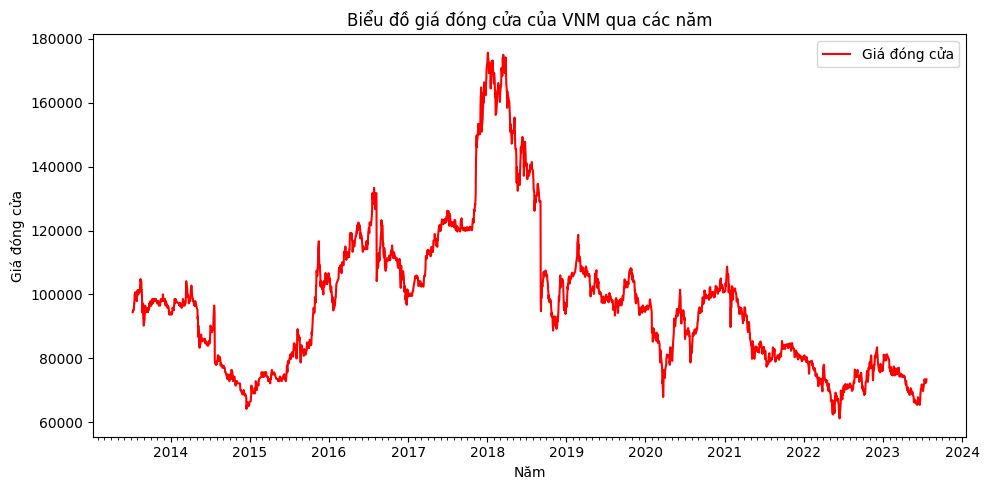

In [6]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Chuyển đổi định dạng các cột giá thành số thực
df['Đóng cửa'] = df['Đóng cửa'].str.replace(',', '').astype(float)
df['Mở cửa'] = df['Mở cửa'].str.replace(',', '').astype(float)
df['Cao nhất'] = df['Cao nhất'].str.replace(',', '').astype(float)
df['Thấp nhất'] = df['Thấp nhất'].str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Năm'] = df['Ngày'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngày'], df['Đóng cửa'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [7]:
df1 = pd.DataFrame(df,columns=['Ngày','Đóng cửa'])
df1.index = df1.Ngày
df1.drop('Ngày',axis=1,inplace=True)
df1


#chia tập dữ liệu
data = df1.values
train_data = data[:1500]
test_data = data[1500:]

In [8]:
data

array([[94444.],
       [94444.],
       [95139.],
       ...,
       [72600.],
       [72700.],
       [73500.]])

In [9]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)


#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau


x_train


y_train

[0.2963569134842401,
 0.30242770379791795,
 0.2963569134842401,
 0.30242770379791795,
 0.3145780319617488,
 0.30850724164807086,
 0.3145780319617488,
 0.32065756981190174,
 0.30850724164807086,
 0.3145780319617488,
 0.30850724164807086,
 0.3145780319617488,
 0.3145780319617488,
 0.3145780319617488,
 0.3267283601255797,
 0.3145780319617488,
 0.3145780319617488,
 0.32065756981190174,
 0.3267283601255797,
 0.3267283601255797,
 0.32065756981190174,
 0.3267283601255797,
 0.3267283601255797,
 0.32065756981190174,
 0.32065756981190174,
 0.3267283601255797,
 0.3267283601255797,
 0.32065756981190174,
 0.32065756981190174,
 0.32065756981190174,
 0.3145780319617488,
 0.3145780319617488,
 0.3145780319617488,
 0.32065756981190174,
 0.32065756981190174,
 0.3145780319617488,
 0.30850724164807086,
 0.30850724164807086,
 0.30850724164807086,
 0.30850724164807086,
 0.30850724164807086,
 0.32065756981190174,
 0.3267283601255797,
 0.3267283601255797,
 0.32065756981190174,
 0.32065756981190174,
 0.32065756

In [10]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

# Xây dựng và huấn luyện mô hình

In [15]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')


#huấn luyện mô hình
save_model = "/content/drive/MyDrive/DoAn/DuLieu/DuLieuLuu.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])




Epoch 1/100

Epoch 1: loss improved from inf to 0.11266, saving model to /content/drive/MyDrive/DoAn/DuLieu/DuLieuLuu.keras
29/29 - 6s - 224ms/step - loss: 0.1127
Epoch 2/100

Epoch 2: loss improved from 0.11266 to 0.05892, saving model to /content/drive/MyDrive/DoAn/DuLieu/DuLieuLuu.keras
29/29 - 8s - 279ms/step - loss: 0.0589
Epoch 3/100

Epoch 3: loss improved from 0.05892 to 0.05295, saving model to /content/drive/MyDrive/DoAn/DuLieu/DuLieuLuu.keras
29/29 - 7s - 244ms/step - loss: 0.0530
Epoch 4/100

Epoch 4: loss improved from 0.05295 to 0.05181, saving model to /content/drive/MyDrive/DoAn/DuLieu/DuLieuLuu.keras
29/29 - 7s - 255ms/step - loss: 0.0518
Epoch 5/100

Epoch 5: loss improved from 0.05181 to 0.04821, saving model to /content/drive/MyDrive/DoAn/DuLieu/DuLieuLuu.keras
29/29 - 8s - 273ms/step - loss: 0.0482
Epoch 6/100

Epoch 6: loss did not improve from 0.04821
29/29 - 8s - 263ms/step - loss: 0.0496
Epoch 7/100

Epoch 7: loss improved from 0.04821 to 0.04536, saving model 

In [16]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("/content/drive/MyDrive/DoAn/DuLieu/DuLieuLuu.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


# Tái sử dụng mô hình

In [17]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1500:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


# Độ chính xác của mô hình#

<ipython-input-18-4f5867c1eb90>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
<ipython-input-18-4f5867c1eb90>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


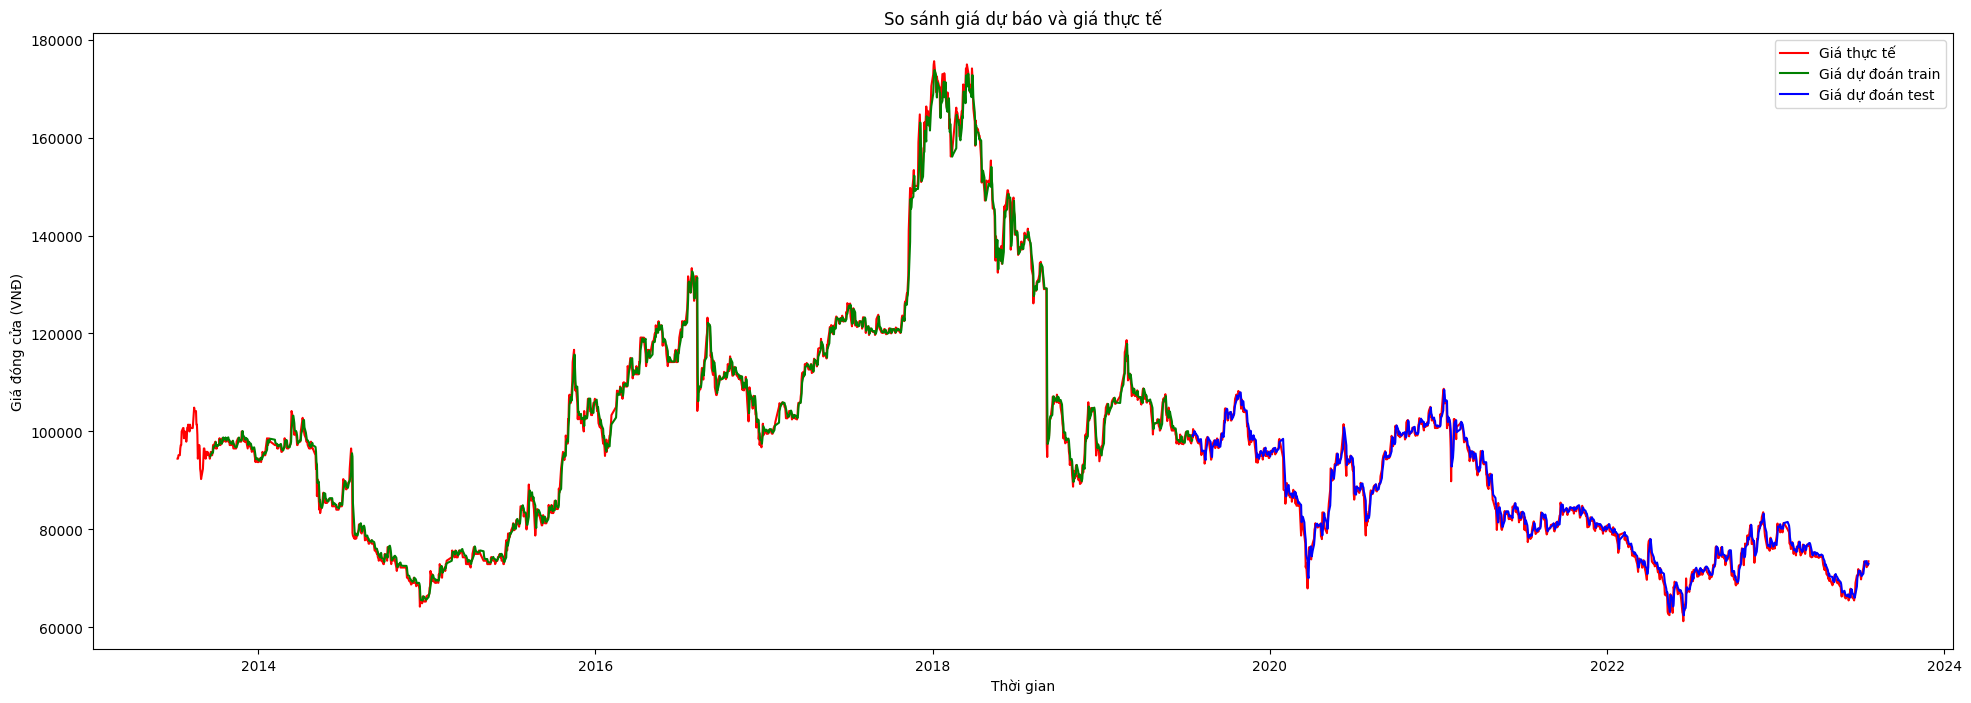

In [18]:
#lập biểu đồ so sánh
train_data1 = df1[50:1500]
test_data1 = df1[1500:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [19]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9927190832105588
Sai số tuyệt đối trung bình trên tập train (VNĐ): 1209.9197117456893
Phần trăm sai số tuyệt đối trung bình tập train: 0.01128611338856849


In [20]:
train_data1

,Đóng cửa,Dự đoán
Ngày,,
2013-09-19,95139.0,94926.976562
2013-09-20,95833.0,95164.554688
2013-09-23,95139.0,95784.554688
2013-09-24,95833.0,95579.562500
2013-09-25,97222.0,95835.507812
...,...,...
2019-07-11,99133.0,99160.078125
2019-07-12,98183.0,99301.085938
2019-07-15,97549.0,98717.273438


In [21]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))



Độ phù hợp tập test: 0.9840725817227218
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1039.9184398320895
Phần trăm sai số tuyệt đối trung bình tập test: 0.012603014223614177


In [22]:
test_data1

,Đóng cửa,Dự đoán
Ngày,,
2019-07-18,98658.0,99114.125000
2019-07-19,100479.0,99048.929688
2019-07-22,99371.0,100074.351562
2019-07-23,99291.0,99840.937500
2019-07-24,99450.0,99543.937500
...,...,...
2023-07-17,72300.0,73529.921875
2023-07-18,72400.0,73015.492188
2023-07-19,72600.0,72762.539062


# Thử dự đoán giá tương lai và so sánh với giá ngày cuối

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


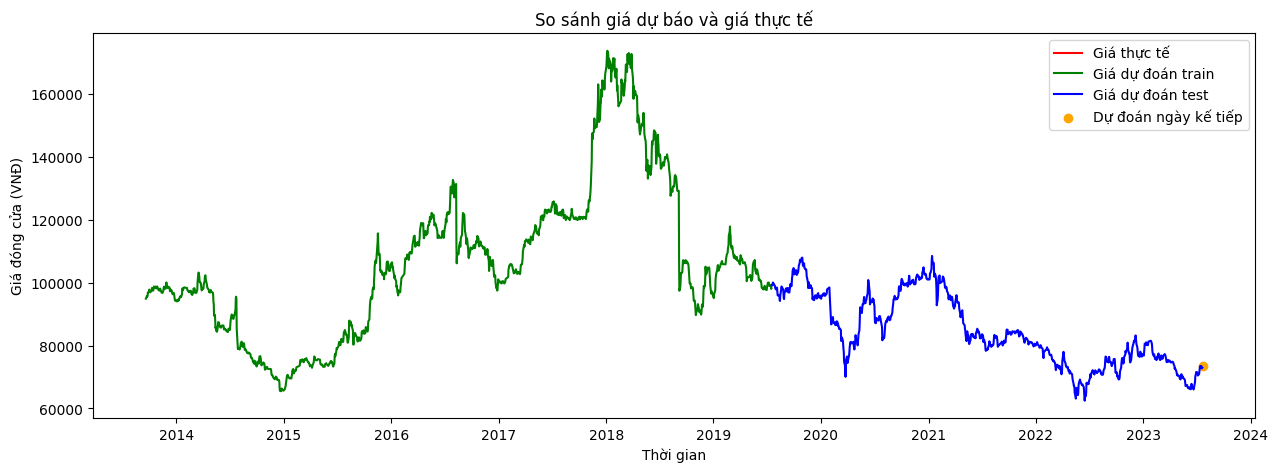

In [23]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Ngày'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Đóng cửa'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Ngày': [next_date], 'Đóng cửa': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Ngày'], df1['Đóng cửa'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


In [24]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Đóng cửa'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Ngày': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)


        Ngày   Giá dự đoán  Giá ngày trước
0 2023-07-22  73456.359375         73500.0
